# Detrend light curves using citlalicue
## Oscar Barragán, Sept. 2020
### Updated Feb 2022
### Powered by [PyTransit](https://github.com/hpparvi/PyTransit) and [george](https://github.com/dfm/george)

# Example to detrend the light curve of Pi Men as observed by _TESS_ in its first sector ([Gandolfi et al., (2018)](https://www.aanda.org/articles/aa/abs/2018/11/aa34289-18/aa34289-18.html); [Huang et al., (2018)](https://iopscience.iop.org/article/10.3847/2041-8213/aaef91)).

### This tutorial assumes that you have a light curve in ascii format, the light curve for this tutorial is provided [here](https://raw.githubusercontent.com/oscaribv/citlalicue/master/pimen.dat)

In [1]:
#Load basic libraries
from __future__ import print_function, division, absolute_import
import numpy as np
import matplotlib.pyplot as plt

#Import the detrend class from citlalicue
from citlalicue.detrending import detrend

#### Let us load the data, since our data file does not have a column corresponding to the error bars, we need to provide an error as an input when calling the class

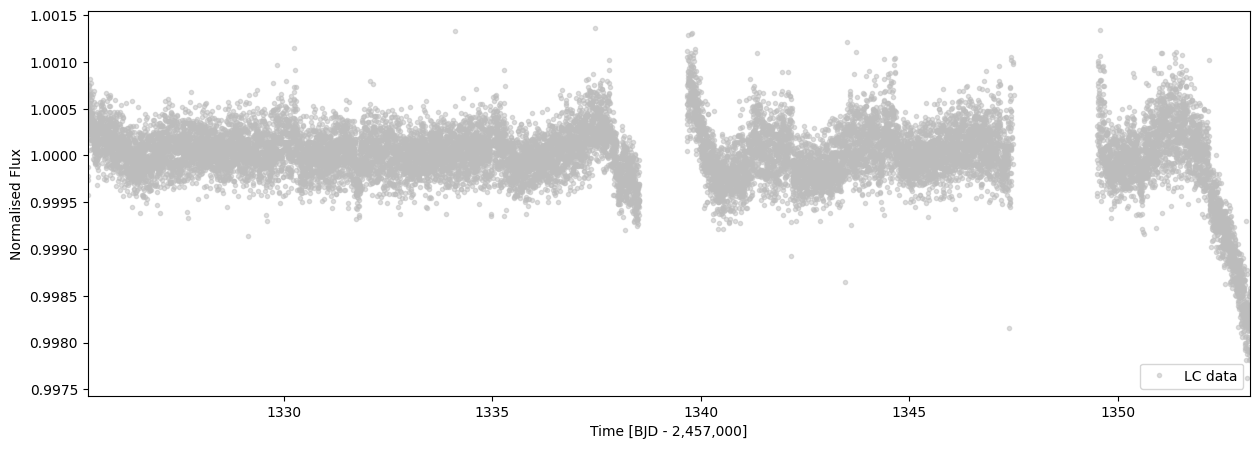

In [2]:
#Create the instance "star" using the "detrend" class
#The name of the input file in this case is "pimen.dat"
#err gives an error bar to the data, given that the pimen.dat file does not have
#tbin (days) indicates to the code the time window that we will use to bin the data 
#(in this example we bin the data to 1 hour) 
#star_name is just the label of the current star
star = detrend("pimen.dat",err=2.2e-4,tbin=1./24.,star_name='PiMen')
#Plot the data
star.plot()

### Add transiting planet parameters, so they can be removed from the detrending routines


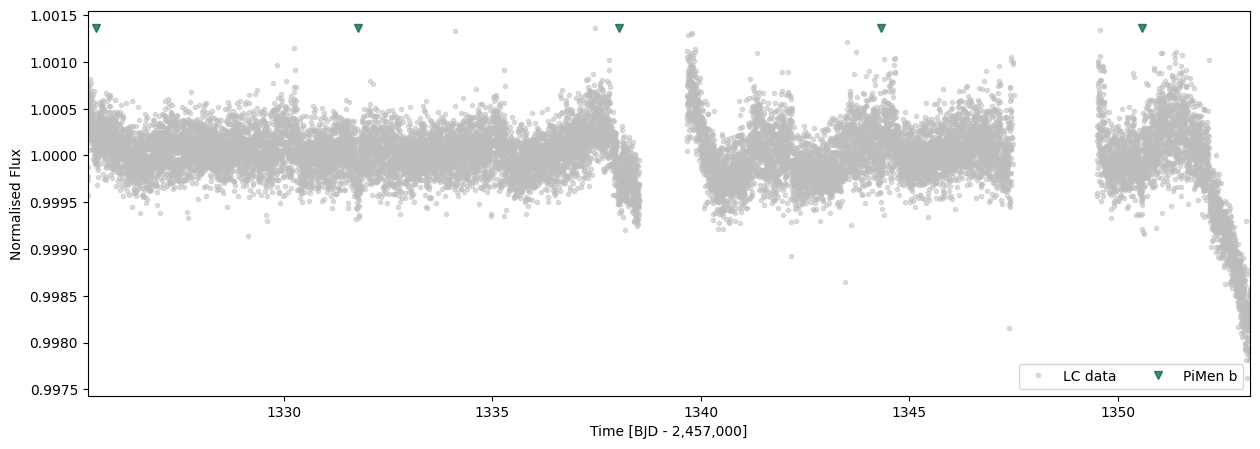

In [4]:
#pars -> [T0, P, a/R*, b, Rp/R*] x Number of planets
#ldc  -> u1, u2
planet_pars = [1325.503055,6.26834,13.10,0.0,0.01721]
ldc = [0.41,0.17]
star.add_transits(pars=planet_pars,ldc=ldc)
star.mask_transits(windows=3./24.)
star.plot()

### Time to create the GP object that will help us to detrend our light curve
### Citlalicue uses the kernels provided by george, now the options are "Exp", "Matern32", "Matern52", and Quasi-Periodic "QP"

In [5]:
#Let us create a GP using a exponential kernel
star.get_gp(Kernel="Matern32",metric=1e3)
#This creates the GP with dummy values for the GP hyperparameters

### Let us see how the GP looks in our data with the dummy initial parameters

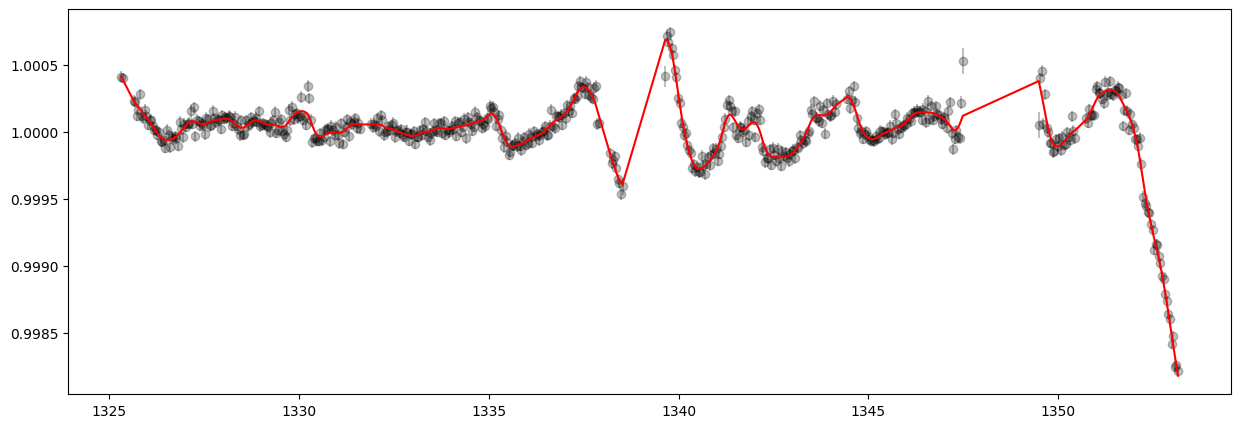

In [6]:
star.predict()

### We can now optimise iteratively for the GP hyper parameters to find the optimal values that describe our data using a sigma clipping algorithm to remove outliers

In [7]:
star.iterative_optimize(sigma=3.5)

Iteration 1
Eliminated 51 points
Iteration 2
Eliminated 12 points
Iteration 3
Eliminated 1 points
Iteration 4
Eliminated 0 points


### Let us see how the GP looks in our data with the optimised parameters

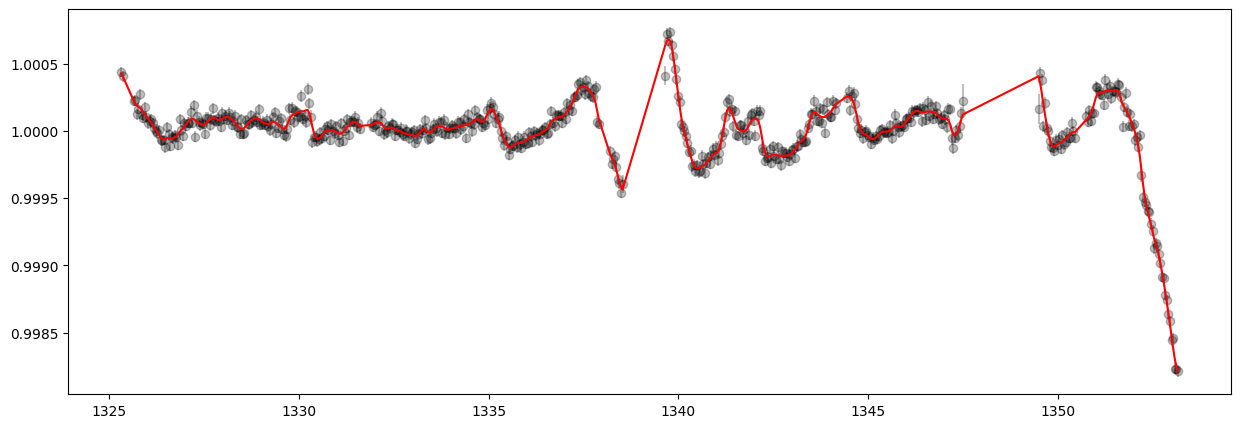

In [8]:
star.predict()

### Now we have a set of values for our GP hyper parameters, we can thus detrend the light curve

In [9]:
#The detrend method can be called with
# 'in' (interpolation), to use an interpolation to compute a lc model to remove from the data (default)
# 'gp', to recompute a GP to compute a lc model to remove from the data (this can perform a
#better detrending but it takes a long time)
star.detrend('in')
#Now we have a file called *detrend.dat file with the detrended light curve

Saving pimen_detrended.dat file


### Check how the light curve looks now

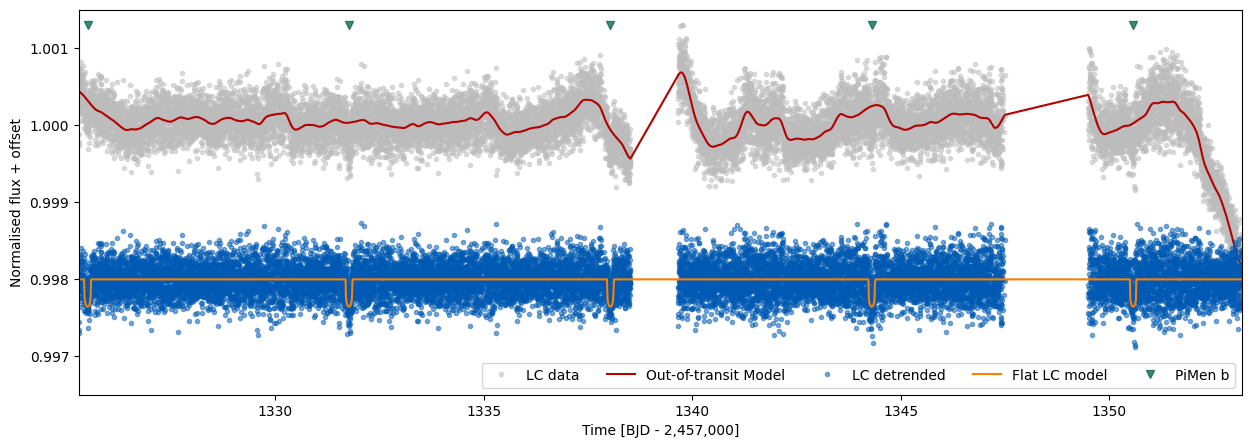

In [10]:
star.plot(save=True,plot_transit_model=True,ylim=[0.9965,1.0015])

### It might be practical for transit fitting routines to fit only the light curve part with transits, we can do this by cutting the transits in the light curve

Saving pimen_detrended_cut.dat file


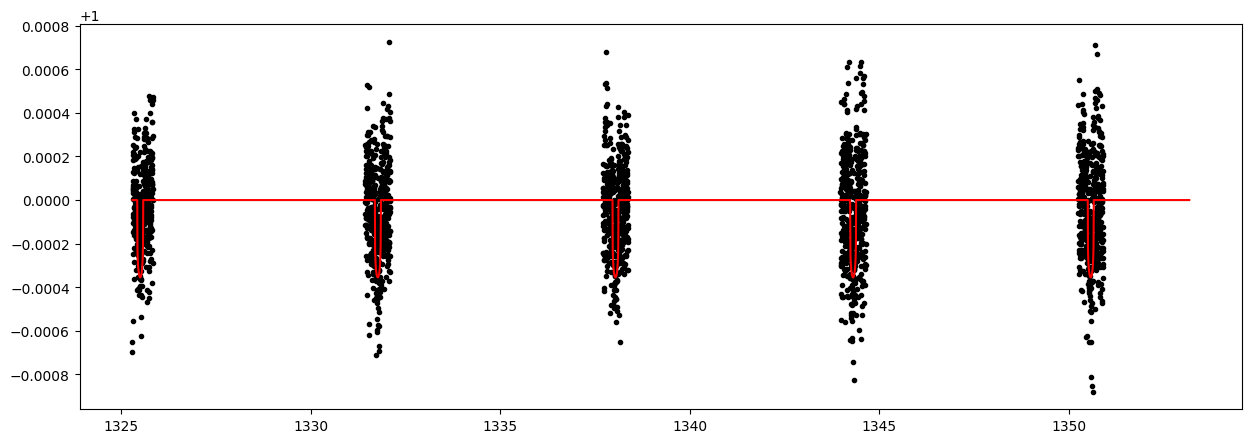

In [11]:
star.cut_transits(windows=[4/24.])
#Now we have cut the transits and they are stored in the *_detrended_cut.dat file
#Let us plot how the new data set looks like
plt.figure(figsize=(15,5))
plt.plot(star.time_cut,star.flux_detrended_cut,'k.')
plt.plot(star.time,star.flux_planet,'r')